Using device: cuda
Number of intent categories: 6

Intent Categories:
  0: flight_status
  1: baggage_issue
  2: terminal_directions
  3: special_assistance
  4: ground_transport
  5: security_customs
Total training samples: 92

Dataset distribution:
  flight_status: 15 samples
  baggage_issue: 15 samples
  terminal_directions: 17 samples
  special_assistance: 15 samples
  ground_transport: 15 samples
  security_customs: 15 samples
Vocabulary size: 258

Sample preprocessing:
Original: What time does flight SQ123 depart?
Cleaned: what time does flight sq123 depart?
Tokens: ['what', 'time', 'does', 'flight', 'sq123', 'depart?']
Indices: [2, 3, 4, 5, 6, 7]
Training samples: 73
Test samples: 19
Number of training batches: 10
Number of test batches: 3
IntentClassifierRNN(
  (embedding): Embedding(258, 64, padding_idx=0)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_feat

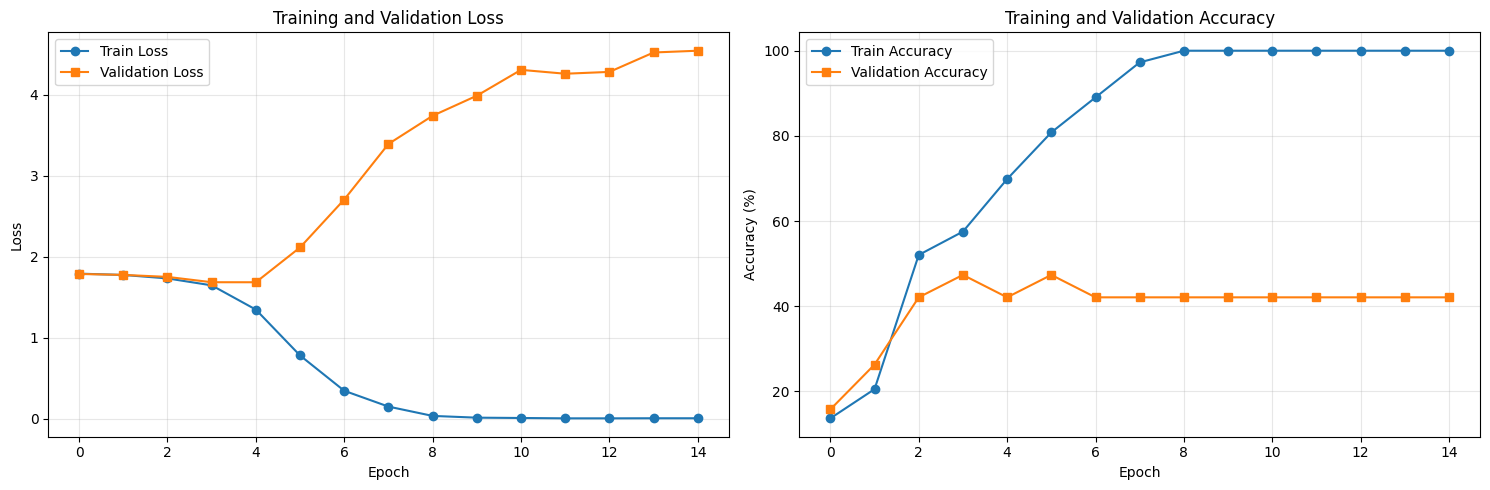

Test Accuracy: 42.11%

Classification Report:
                     precision    recall  f1-score   support

      flight_status       0.43      1.00      0.60         3
      baggage_issue       1.00      0.33      0.50         3
terminal_directions       0.30      0.75      0.43         4
 special_assistance       1.00      0.33      0.50         3
   ground_transport       0.00      0.00      0.00         3
   security_customs       0.00      0.00      0.00         3

           accuracy                           0.42        19
          macro avg       0.45      0.40      0.34        19
       weighted avg       0.45      0.42      0.34        19



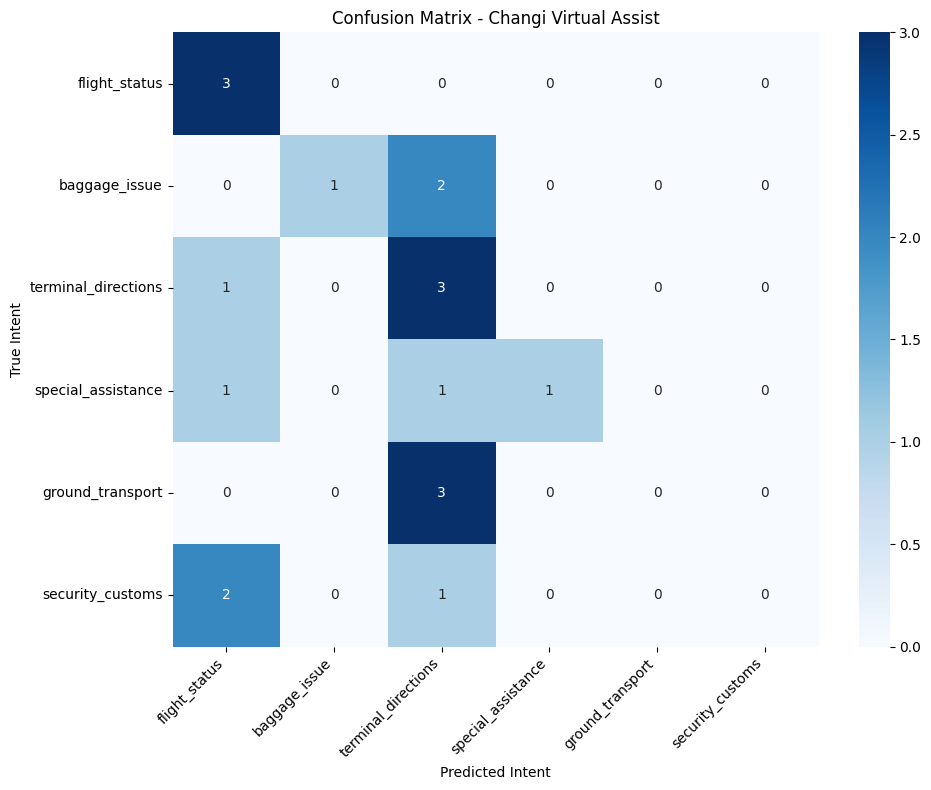

Testing intent prediction:


Query: 'Where can I find my luggage?'
----------------------------------------------------------------------
1. terminal_directions...........  37.22%
2. ground_transport..............  19.11%
3. baggage_issue.................  16.39%

Query: 'Is my Emirates flight delayed?'
----------------------------------------------------------------------
1. flight_status.................  63.00%
2. security_customs..............  14.62%
3. ground_transport..............   7.31%

Query: 'I need a wheelchair'
----------------------------------------------------------------------
1. special_assistance............  45.61%
2. terminal_directions...........  13.65%
3. baggage_issue.................  12.00%

Query: 'How to get to the city center?'
----------------------------------------------------------------------
1. terminal_directions...........  75.39%
2. ground_transport..............  13.00%
3. baggage_issue.................   9.28%

Query: 'Can I bring this in my c

In [2]:
"""
Changi Virtual Assist Triage - RNN Text Classification
Airport Customer Service Intent Classification System
For use in Jupyter Notebook (.ipynb)
"""

# ============================================================================
# CELL 1: Install and Import Dependencies
# ============================================================================

# Uncomment if needed:
# !pip install torch torchvision torchaudio
# !pip install datasets
# !pip install scikit-learn matplotlib seaborn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import numpy as np
import pandas as pd
from collections import Counter
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================================
# CELL 2: Define Changi Airport Intent Categories
# ============================================================================

# Intent mapping for Changi Virtual Assist
CHANGI_INTENTS = {
    0: "flight_status",
    1: "baggage_issue",
    2: "terminal_directions",
    3: "special_assistance",
    4: "ground_transport",
    5: "security_customs"
}

NUM_CLASSES = len(CHANGI_INTENTS)
print(f"Number of intent categories: {NUM_CLASSES}")
print("\nIntent Categories:")
for idx, intent in CHANGI_INTENTS.items():
    print(f"  {idx}: {intent}")

# ============================================================================
# CELL 3: Create Changi-Specific Dataset
# ============================================================================

# Sample Changi Airport customer service queries
CHANGI_DATA = [
    # Flight status queries (0)
    ("What time does flight SQ123 depart?", 0),
    ("Has the gate changed for my Singapore Airlines flight?", 0),
    ("Is my flight to Tokyo delayed?", 0),
    ("When will boarding start for gate C21?", 0),
    ("Check flight arrival time from London", 0),
    ("My flight status please", 0),
    ("What gate is Emirates EK405?", 0),
    ("Flight departure information needed", 0),
    ("Show me departures to Bangkok", 0),
    ("Is SQ308 on time?", 0),
    ("Gate information for my Qantas flight", 0),
    ("When does check-in close for BA12?", 0),
    ("Has my flight started boarding?", 0),
    ("What's the status of incoming flight from Sydney?", 0),
    ("Where can I see the departure board?", 0),

    # Baggage issues (1)
    ("My luggage hasn't arrived at the carousel", 1),
    ("I need to report damaged baggage", 1),
    ("Where do I claim lost luggage?", 1),
    ("My suitcase is missing", 1),
    ("Baggage delayed what should I do", 1),
    ("Found someone else's bag instead of mine", 1),
    ("How to file baggage claim", 1),
    ("Checked bag not on carousel", 1),
    ("My bag arrived damaged need help", 1),
    ("Lost baggage counter location", 1),
    ("Tag says my luggage went to wrong city", 1),
    ("Bag didn't make connecting flight", 1),
    ("Need to report missing items from luggage", 1),
    ("Where is baggage services office?", 1),
    ("Suitcase handle broken during flight", 1),

    # Terminal directions (2)
    ("How do I get to Jewel from Terminal 2?", 2),
    ("Where is immigration in Terminal 3?", 2),
    ("Which way to the transfer desk?", 2),
    ("Where can I find the SilverKris lounge?", 2),
    ("Directions to baggage claim area", 2),
    ("How to walk to Terminal 1 from T3?", 2),
    ("Where are the charging stations?", 2),
    ("Location of prayer room please", 2),
    ("How do I get to the smoking area?", 2),
    ("Where is the nearest restroom?", 2),
    ("Directions to Changi Lounge", 2),
    ("How to reach the butterfly garden?", 2),
    ("Where can I find currency exchange?", 2),
    ("Map to duty free shops", 2),
    ("How to get to departure gates from arrival hall?", 2),
    ("Where is the medical clinic?", 2),
    ("Location of children's play area", 2),

    # Special assistance (3)
    ("I need wheelchair assistance", 3),
    ("Traveling with infant need baby care room", 3),
    ("Can I get help with mobility?", 3),
    ("Where to request special assistance?", 3),
    ("Need help for elderly passenger", 3),
    ("Stroller rental available?", 3),
    ("Assistance for visually impaired passenger", 3),
    ("I'm traveling alone with a toddler need support", 3),
    ("Require escort service through airport", 3),
    ("Medical assistance needed", 3),
    ("Where can I get a wheelchair?", 3),
    ("Help needed for disabled traveler", 3),
    ("Nursing room location", 3),
    ("Do you provide meet and assist service?", 3),
    ("Special needs passenger support", 3),

    # Ground transport (4)
    ("How do I get to downtown Singapore?", 4),
    ("Where is the taxi stand?", 4),
    ("Is there a bus to the city?", 4),
    ("MRT station location from terminal", 4),
    ("How much is Grab to Marina Bay?", 4),
    ("Shuttle bus to nearby hotels", 4),
    ("Where can I rent a car?", 4),
    ("Public transport options to Sentosa", 4),
    ("Taxi queue waiting time", 4),
    ("How to book airport shuttle?", 4),
    ("Train to Orchard Road", 4),
    ("Private car pickup point", 4),
    ("Bus schedule to city center", 4),
    ("Cheapest way to get downtown", 4),
    ("Where do limousines pick up passengers?", 4),

    # Security/Customs (5)
    ("What items can I bring in carry-on?", 5),
    ("Liquid restrictions for hand luggage", 5),
    ("Do I need to declare this purchase?", 5),
    ("Where is customs declaration?", 5),
    ("Security screening procedures", 5),
    ("Can I bring duty free alcohol?", 5),
    ("Immigration form filling help", 5),
    ("Passport control location", 5),
    ("What's the customs allowance?", 5),
    ("Do I go through security again for transfer?", 5),
    ("Prohibited items list", 5),
    ("Visa on arrival information", 5),
    ("Customs declaration for food items", 5),
    ("How early to arrive for security check?", 5),
    ("Can I bring batteries in checked luggage?", 5),
]

print(f"Total training samples: {len(CHANGI_DATA)}")

# Show distribution
intent_counts = Counter([label for _, label in CHANGI_DATA])
print("\nDataset distribution:")
for intent_id, count in sorted(intent_counts.items()):
    print(f"  {CHANGI_INTENTS[intent_id]}: {count} samples")

# ============================================================================
# CELL 4: Text Preprocessing
# ============================================================================

class TextPreprocessor:
    """Handles text cleaning and tokenization"""

    def __init__(self):
        self.vocab = {'<PAD>': 0, '<UNK>': 1}
        self.word_to_idx = self.vocab.copy()
        self.idx_to_word = {v: k for k, v in self.vocab.items()}

    def clean_text(self, text):
        """Clean and normalize text"""
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s?!]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def tokenize(self, text):
        """Simple whitespace tokenization"""
        return text.split()

    def build_vocab(self, texts, min_freq=1):
        """Build vocabulary from texts"""
        word_freq = Counter()
        for text in texts:
            cleaned = self.clean_text(text)
            tokens = self.tokenize(cleaned)
            word_freq.update(tokens)

        # Add words to vocabulary
        for word, freq in word_freq.items():
            if freq >= min_freq and word not in self.word_to_idx:
                idx = len(self.word_to_idx)
                self.word_to_idx[word] = idx
                self.idx_to_word[idx] = word

        print(f"Vocabulary size: {len(self.word_to_idx)}")
        return self.word_to_idx

    def text_to_indices(self, text):
        """Convert text to indices"""
        cleaned = self.clean_text(text)
        tokens = self.tokenize(cleaned)
        return [self.word_to_idx.get(token, self.word_to_idx['<UNK>'])
                for token in tokens]

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Build vocabulary from training data
texts = [text for text, _ in CHANGI_DATA]
vocab = preprocessor.build_vocab(texts, min_freq=1)

# Show sample preprocessing
sample_text = "What time does flight SQ123 depart?"
print(f"\nSample preprocessing:")
print(f"Original: {sample_text}")
print(f"Cleaned: {preprocessor.clean_text(sample_text)}")
print(f"Tokens: {preprocessor.tokenize(preprocessor.clean_text(sample_text))}")
print(f"Indices: {preprocessor.text_to_indices(sample_text)}")

# ============================================================================
# CELL 5: Create PyTorch Dataset
# ============================================================================

class AirportIntentDataset(Dataset):
    """PyTorch Dataset for airport intent classification"""

    def __init__(self, texts, labels, preprocessor):
        self.texts = texts
        self.labels = labels
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Convert text to indices
        indices = self.preprocessor.text_to_indices(text)

        return {
            'text': text,
            'indices': torch.LongTensor(indices),
            'label': torch.LongTensor([label]),
            'length': len(indices)
        }

def collate_fn(batch):
    """Custom collate function for padding sequences"""
    texts = [item['text'] for item in batch]
    indices = [item['indices'] for item in batch]
    labels = torch.cat([item['label'] for item in batch])
    lengths = torch.LongTensor([item['length'] for item in batch])

    # Pad sequences
    padded_indices = pad_sequence(indices, batch_first=True, padding_value=0)

    return {
        'text': texts,
        'indices': padded_indices,
        'labels': labels,
        'lengths': lengths
    }

# Split data
texts, labels = zip(*CHANGI_DATA)
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Create datasets
train_dataset = AirportIntentDataset(X_train, y_train, preprocessor)
test_dataset = AirportIntentDataset(X_test, y_test, preprocessor)

# Create dataloaders
BATCH_SIZE = 8
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# ============================================================================
# CELL 6: Define RNN Model Architecture
# ============================================================================

class IntentClassifierRNN(nn.Module):
    """RNN-based intent classifier with LSTM"""

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes,
                 num_layers=2, dropout=0.3, bidirectional=True):
        super(IntentClassifierRNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # LSTM layer
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional,
            batch_first=True
        )

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim * self.num_directions, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, lengths):
        # x: (batch_size, seq_len)
        batch_size = x.size(0)

        # Embedding: (batch_size, seq_len, embedding_dim)
        embedded = self.embedding(x)

        # Pack padded sequences
        packed = pack_padded_sequence(
            embedded,
            lengths.cpu(),
            batch_first=True,
            enforce_sorted=False
        )

        # LSTM
        packed_output, (hidden, cell) = self.lstm(packed)

        # Use final hidden state
        # hidden: (num_layers * num_directions, batch_size, hidden_dim)
        if self.bidirectional:
            # Concatenate forward and backward hidden states from last layer
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]

        # hidden: (batch_size, hidden_dim * num_directions)

        # Fully connected layers
        out = self.dropout(hidden)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out

# Model hyperparameters
VOCAB_SIZE = len(preprocessor.word_to_idx)
EMBEDDING_DIM = 64
HIDDEN_DIM = 128
NUM_LAYERS = 2
DROPOUT = 0.3
BIDIRECTIONAL = True

# Initialize model
model = IntentClassifierRNN(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=NUM_CLASSES,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    bidirectional=BIDIRECTIONAL
).to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# ============================================================================
# CELL 7: Define Training Function
# ============================================================================

def train_epoch(model, data_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in data_loader:
        indices = batch['indices'].to(device)
        labels = batch['labels'].to(device)
        lengths = batch['lengths']

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(indices, lengths)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Clip gradients to prevent explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()

        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

def evaluate(model, data_loader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            indices = batch['indices'].to(device)
            labels = batch['labels'].to(device)
            lengths = batch['lengths']

            # Forward pass
            outputs = model(indices, lengths)
            loss = criterion(outputs, labels)

            # Statistics
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy, all_predictions, all_labels

# ============================================================================
# CELL 8: Train the Model
# ============================================================================

# Training hyperparameters
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
PATIENCE = 10  # For early stopping

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Early stopping
best_val_loss = float('inf')
patience_counter = 0

print("Starting training...\n")

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Evaluate
    val_loss, val_acc, _, _ = evaluate(model, test_loader, criterion, device)

    # Update scheduler
    scheduler.step(val_loss)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print progress
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_changi_rnn_model.pth')
        print("  ✓ New best model saved!")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

    print()

print("Training completed!")

# Load best model
model.load_state_dict(torch.load('best_changi_rnn_model.pth'))

# ============================================================================
# CELL 9: Visualize Training History
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Validation Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# CELL 10: Evaluate on Test Set
# ============================================================================

# Get predictions
_, test_acc, y_pred, y_true = evaluate(model, test_loader, criterion, device)

print(f"Test Accuracy: {test_acc:.2f}%\n")

# Classification report
intent_names = [CHANGI_INTENTS[i] for i in range(NUM_CLASSES)]
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=intent_names, zero_division=0))

# ============================================================================
# CELL 11: Confusion Matrix
# ============================================================================

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=intent_names, yticklabels=intent_names)
plt.title('Confusion Matrix - Changi Virtual Assist')
plt.ylabel('True Intent')
plt.xlabel('Predicted Intent')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ============================================================================
# CELL 12: Inference Function
# ============================================================================

def predict_intent(model, text, preprocessor, device, top_k=3):
    """Predict intent for a single text query"""
    model.eval()

    # Preprocess
    indices = preprocessor.text_to_indices(text)
    length = len(indices)

    # Convert to tensors
    indices_tensor = torch.LongTensor(indices).unsqueeze(0).to(device)
    length_tensor = torch.LongTensor([length])

    # Predict
    with torch.no_grad():
        outputs = model(indices_tensor, length_tensor)
        probabilities = torch.softmax(outputs, dim=1)[0]

    # Get top k predictions
    top_probs, top_indices = torch.topk(probabilities, min(top_k, NUM_CLASSES))

    results = []
    for prob, idx in zip(top_probs, top_indices):
        results.append({
            'intent': CHANGI_INTENTS[idx.item()],
            'confidence': prob.item() * 100
        })

    return results

# ============================================================================
# CELL 13: Test Inference
# ============================================================================

# Test queries
test_queries = [
    "Where can I find my luggage?",
    "Is my Emirates flight delayed?",
    "I need a wheelchair",
    "How to get to the city center?",
    "Can I bring this in my carry-on?",
    "Where is Terminal 2?",
]

print("Testing intent prediction:\n")
print("=" * 70)

for query in test_queries:
    print(f"\nQuery: '{query}'")
    print("-" * 70)

    predictions = predict_intent(model, query, preprocessor, device, top_k=3)

    for i, pred in enumerate(predictions, 1):
        print(f"{i}. {pred['intent']:.<30} {pred['confidence']:>6.2f}%")

print("\n" + "=" * 70)

# ============================================================================
# CELL 14: Interactive Prediction
# ============================================================================

def interactive_demo():
    """Interactive demo for testing the model"""
    print("\n" + "="*70)
    print("Changi Virtual Assist - Intent Classification Demo")
    print("="*70)
    print("\nEnter passenger queries to classify (type 'quit' to exit)\n")

    while True:
        query = input("Enter query: ").strip()

        if query.lower() in ['quit', 'exit', 'q']:
            print("\nThank you for using Changi Virtual Assist!")
            break

        if not query:
            continue

        print("\nPredictions:")
        print("-" * 70)

        predictions = predict_intent(model, query, preprocessor, device, top_k=3)

        for i, pred in enumerate(predictions, 1):
            bar = "█" * int(pred['confidence'] / 2)
            print(f"{i}. {pred['intent']:.<25} {pred['confidence']:>6.2f}% {bar}")

        print("\n")

# Uncomment to run interactive demo:
# interactive_demo()

# ============================================================================
# CELL 15: Model Analysis and Summary
# ============================================================================

print("\n" + "="*70)
print("MODEL SUMMARY")
print("="*70)

print(f"\nArchitecture: Bidirectional LSTM")
print(f"Vocabulary Size: {VOCAB_SIZE}")
print(f"Embedding Dimension: {EMBEDDING_DIM}")
print(f"Hidden Dimension: {HIDDEN_DIM}")
print(f"Number of Layers: {NUM_LAYERS}")
print(f"Dropout Rate: {DROPOUT}")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"\nTotal Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Test Accuracy: {test_acc:.2f}%")

print("\n" + "="*70)
print("INTENT CATEGORIES")
print("="*70)
for idx, intent in CHANGI_INTENTS.items():
    print(f"{idx}. {intent}")

print("\n" + "="*70)
print("USAGE INSTRUCTIONS")
print("="*70)
print("""
To use this model:

1. Preprocess new text:
   indices = preprocessor.text_to_indices("your query here")

2. Make predictions:
   predictions = predict_intent(model, "your query", preprocessor, device)

3. The model returns top-k intents with confidence scores

4. Use the interactive demo for testing:
   interactive_demo()
""")

# ============================================================================
# CELL 16: Save Model and Preprocessor
# ============================================================================

# Save complete model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'vocab': preprocessor.word_to_idx,
    'intents': CHANGI_INTENTS,
    'hyperparameters': {
        'vocab_size': VOCAB_SIZE,
        'embedding_dim': EMBEDDING_DIM,
        'hidden_dim': HIDDEN_DIM,
        'num_classes': NUM_CLASSES,
        'num_layers': NUM_LAYERS,
        'dropout': DROPOUT,
        'bidirectional': BIDIRECTIONAL
    },
    'test_accuracy': test_acc
}

torch.save(checkpoint, 'changi_rnn_complete.pth')
print("\n✓ Model checkpoint saved as 'changi_rnn_complete.pth'")

# ============================================================================
# CELL 17: Load Model (for future use)
# ============================================================================

def load_changi_model(checkpoint_path):
    """Load saved model"""
    checkpoint = torch.load(checkpoint_path)

    # Recreate preprocessor
    preprocessor_loaded = TextPreprocessor()
    preprocessor_loaded.word_to_idx = checkpoint['vocab']
    preprocessor_loaded.idx_to_word = {v: k for k, v in checkpoint['vocab'].items()}

    # Recreate model
    hp = checkpoint['hyperparameters']
    model_loaded = IntentClassifierRNN(
        vocab_size=hp['vocab_size'],
        embedding_dim=hp['embedding_dim'],
        hidden_dim=hp['hidden_dim'],
        num_classes=hp['num_classes'],
        num_layers=hp['num_layers'],
        dropout=hp['dropout'],
        bidirectional=hp['bidirectional']
    )

    model_loaded.load_state_dict(checkpoint['model_state_dict'])
    model_loaded.to(device)
    model_loaded.eval()

    return model_loaded, preprocessor_loaded, checkpoint['intents']

# Example usage:
# model_loaded, preprocessor_loaded, intents = load_changi_model('changi_rnn_complete.pth')

print("\n" + "="*70)
print("Setup Complete! The model is ready for use.")
print("="*70)